In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score

#Carregar o dataset
df = pd.read_csv("data\\health_lifestyle_dataset.csv")

#Converter variáveis categóricas
df["gender"] = df["gender"].map({"Male": 1, "Female": 0})

#Remover linhas com valores nulos
df = df.dropna().reset_index(drop=True)

#Separar variáveis independentes e dependente
X = df.drop(["id", "disease_risk"], axis=1)
X = X.astype(float)
y = df["disease_risk"]

#Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

#Treinar o modelo
model = RandomForestClassifier(random_state=12)
model.fit(X_train, y_train)

#Avaliar o modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisão do modelo: {accuracy:.2%}\n")


Precisão do modelo: 75.07%



Importância das variáveis:

daily_steps          0.111190
calories_consumed    0.110165
bmi                  0.100388
cholesterol          0.098615
systolic_bp          0.092319
sleep_hours          0.090389
age                  0.088046
diastolic_bp         0.086453
water_intake_l       0.083375
resting_hr           0.082748
gender               0.015441
alcohol              0.014248
family_history       0.014082
smoker               0.012542
dtype: float64


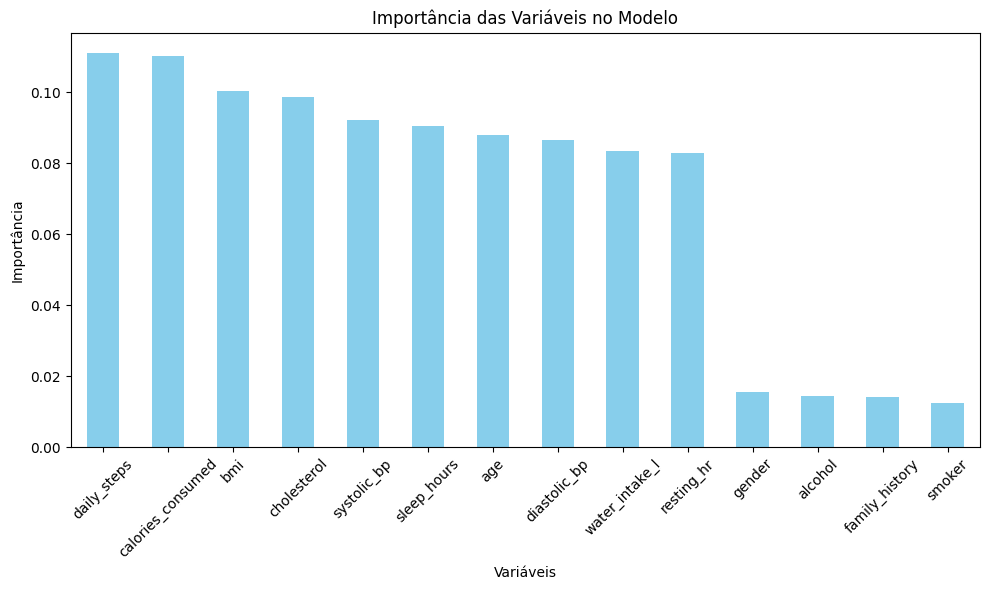

In [4]:
#Importância das variáveis
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Importância das variáveis:\n")
print(importances)

#Gráfico da importância das variáveis
fig, ax = plt.subplots(figsize=(10,6))
importances.plot(kind='bar', color='skyblue', ax=ax)  # especifica o eixo explicitamente
ax.set_title("Importância das Variáveis no Modelo")
ax.set_ylabel("Importância")
ax.set_xlabel("Variáveis")
ax.set_xticklabels(importances.index, rotation=45)
plt.tight_layout()
plt.show()

Podemos ver que enquanto algumas variáveis são mais imporatnte que outras, o que realmente faz a diferença é o conjunto de hábitos saudáveis, não somente alguns poucous.

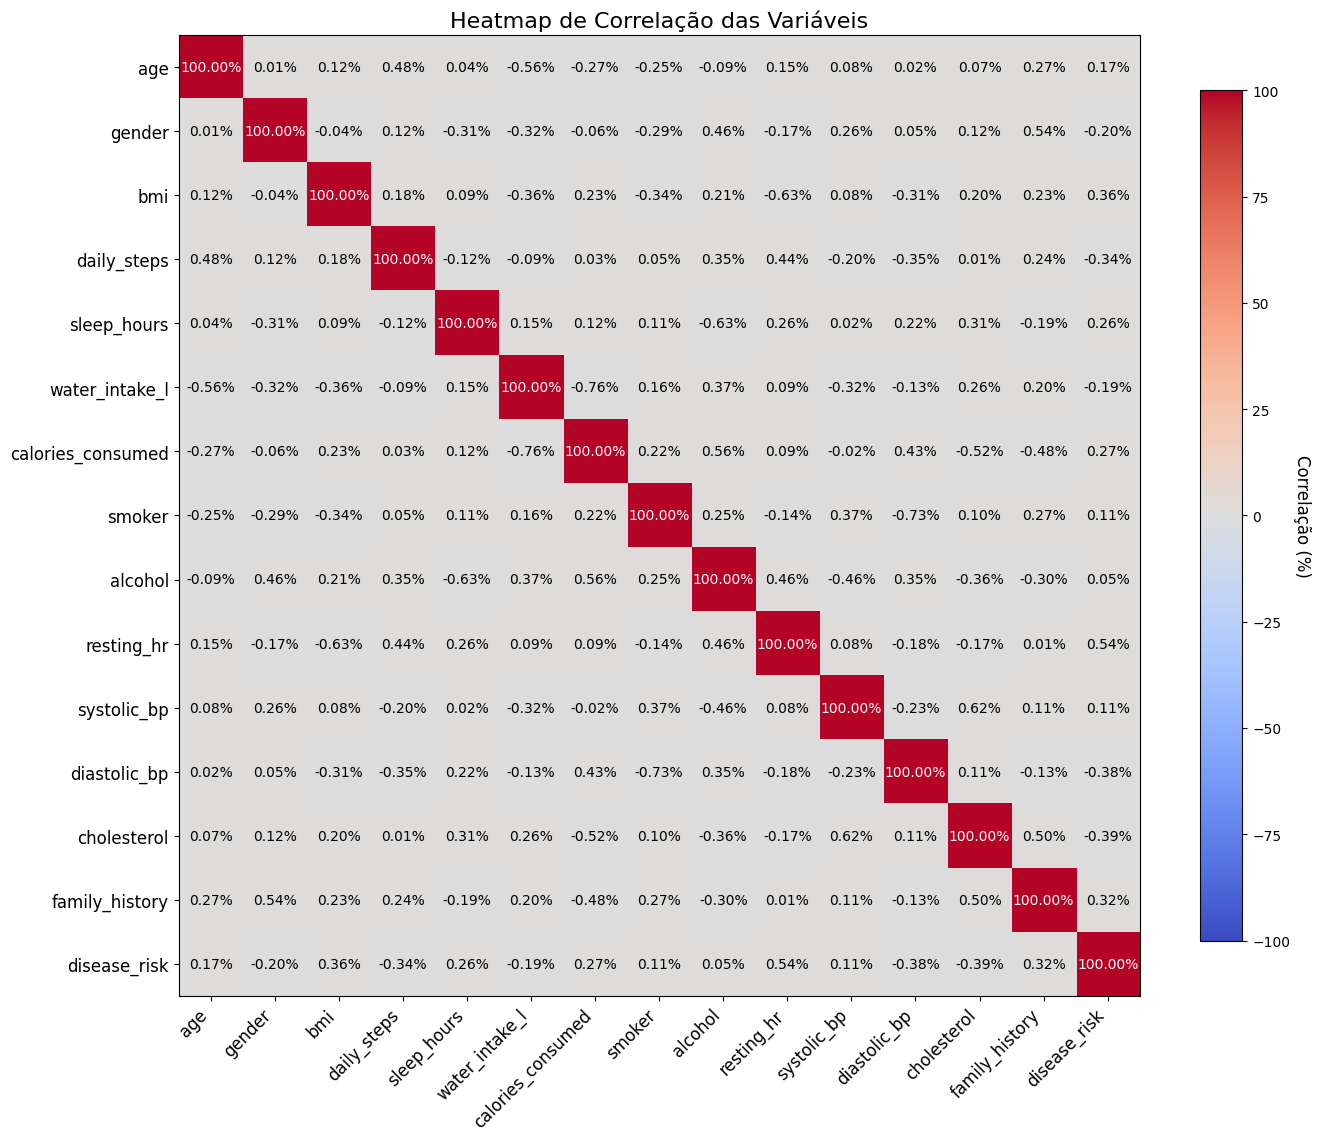

In [5]:
# Calcular a correlação das colunas numéricas
corr = df.drop(columns=["id"]).astype(float).corr()

# Multiplicar por 100 para exibir em porcentagem
corr_percent = corr * 100

# Criar figura maior para melhor legibilidade
fig, ax = plt.subplots(figsize=(14,12))

# Criar o heatmap com cores divergentes
im = ax.imshow(corr_percent, cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')

# Adicionar rótulos nos eixos
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(corr.columns, fontsize=12)

# Adicionar valores dentro das células com cores contrastantes e fonte maior
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr_percent.iloc[i, j]
        color = "black" if abs(value) < 50 else "white"  # contraste para legibilidade
        ax.text(j, i, f"{value:.2f}%", ha="center", va="center", color=color, fontsize=10)

# Adicionar barra de cores
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Correlação (%)", rotation=270, labelpad=15, fontsize=12)

plt.title("Heatmap de Correlação das Variáveis", fontsize=16)
plt.tight_layout()
plt.show()

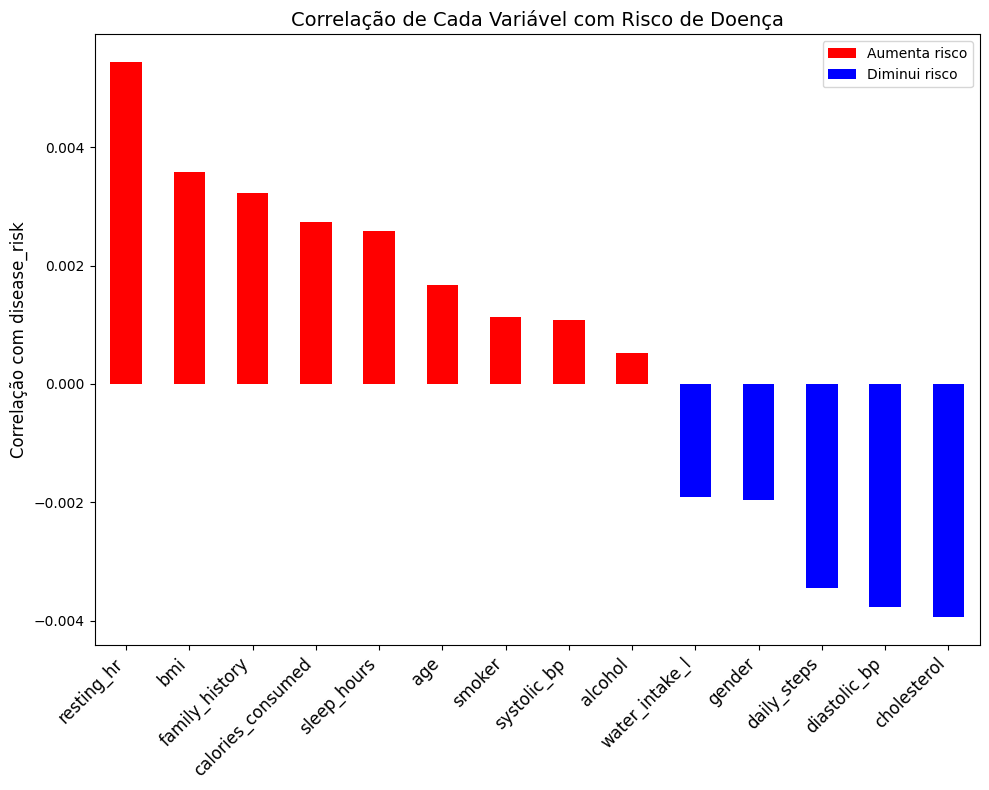

In [6]:
# Selecionar apenas variáveis numéricas
X = df.drop(columns=["id", "disease_risk"]).astype(float)
y = df["disease_risk"]

# Calcular correlação de cada variável com o risco de doença
corr_with_target = X.corrwith(y).sort_values(ascending=False)

# Gráfico de barras colorido
fig, ax = plt.subplots(figsize=(10,8))
colors = corr_with_target.apply(lambda x: 'red' if x > 0 else 'blue')  # vermelho aumenta risco, azul diminui

corr_with_target.plot(kind='bar', color=colors, ax=ax)
ax.set_ylabel("Correlação com disease_risk", fontsize=12)
ax.set_title("Correlação de Cada Variável com Risco de Doença", fontsize=14)
ax.set_xticklabels(corr_with_target.index, rotation=45, ha='right', fontsize=12)

# Legenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Aumenta risco'),
                   Patch(facecolor='blue', label='Diminui risco')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

Neste gráfico, vemos a correlação do valor da variável (quanto maior) e como o valor afeta a decisão do risco de doença

Esse gráfico é bom para analisar correlações para analisar estudos e tirar novas conclusões

Vermelhos: Quanto mais, mais risco
Azuis: Quanto mais, menos risco

In [ ]:
# Variáveis relacionadas à saúde física
physical_vars = ['daily_steps', 'bmi', 'sleep_hours', 'water_intake_l', 'cholesterol']

# Calcular médias
means = df[physical_vars].mean().reset_index(drop=True)

# Função para avaliar saúde física
def classify_health(row):
    score = 0
    
    # daily_steps: maior que média = saudável
    if row['daily_steps'] >= means['daily_steps']:
        score += 1
        
    # bmi: mais próximo de 22-25 = saudável (faixa média)
    if 18.5 <= row['bmi'] <= 25:
        score += 1
        
    # sleep_hours: maior que média = saudável
    if row['sleep_hours'] >= means['sleep_hours']:
        score += 1
        
    # water_intake_l: maior que média = saudável
    if row['water_intake_l'] >= means['water_intake_l']:
        score += 1
        
    # cholesterol: menor que média = saudável
    if row['cholesterol'] <= means['cholesterol']:
        score += 1
        
    # Definir limiar: pelo menos metade das variáveis dentro da faixa saudável
    return 'Fisicamente Saudável' if score >= 3 else 'Não Saudável'

# Aplicar função ao DataFrame
df['physical_health'] = df.apply(classify_health, axis=1)

# Visualizar
df[['id','daily_steps','bmi','sleep_hours','water_intake_l','cholesterol','physical_health']]


,id,daily_steps,bmi,sleep_hours,water_intake_l,cholesterol,physical_health
0,1,4198,20.5,3.9,3.4,240,Não Saudável
1,2,14359,33.3,9.0,4.7,207,Fisicamente Saudável
2,3,1817,31.6,6.6,4.2,296,Não Saudável
3,4,15772,38.2,3.6,2.0,175,Não Saudável
4,5,6037,33.6,3.8,4.0,294,Não Saudável
...,...,...,...,...,...,...,...
99995,99996,4726,33.1,3.9,2.0,282,Não Saudável
99996,99997,11554,35.1,4.5,3.1,192,Fisicamente Saudável
99997,99998,3924,18.9,3.8,1.0,218,Não Saudável
99998,99999,16110,27.8,5.6,0.8,188,Não Saudável


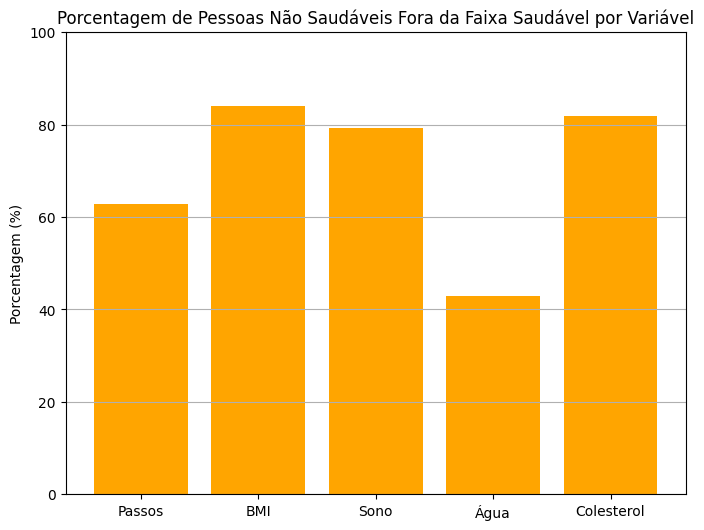

In [15]:
# Filtrar apenas pessoas não saudáveis
nao_saudavel_df = df[df['physical_health'] == 'Não Saudável']
total = len(nao_saudavel_df)

# Calcular porcentagem de pessoas fora da faixa saudável
fatores = []

# daily_steps: menos de 10000 passos
fatores.append((nao_saudavel_df['daily_steps'] < 10000).sum() / total * 100)

# bmi: fora do intervalo 18.5-24.9
fatores.append(((nao_saudavel_df['bmi'] < 18.5) | (nao_saudavel_df['bmi'] > 24.9)).sum() / total * 100)

# sleep_hours: fora do intervalo 7-9 horas
fatores.append(((nao_saudavel_df['sleep_hours'] < 7) | (nao_saudavel_df['sleep_hours'] > 9)).sum() / total * 100)

# water_intake_l: menos de 2 litros
fatores.append((nao_saudavel_df['water_intake_l'] < 2).sum() / total * 100)

# cholesterol: maior ou igual a 190
fatores.append((nao_saudavel_df['cholesterol'] >= 190).sum() / total * 100)

# Plotar gráfico
plt.figure(figsize=(8,6))
plt.bar(['Passos','BMI','Sono','Água','Colesterol'], fatores, color='orange')
plt.title('Porcentagem de Pessoas Não Saudáveis Fora da Faixa Saudável por Variável')
plt.ylabel('Porcentagem (%)')
plt.ylim(0,100)
plt.grid(axis='y')
plt.show()